### The Cross Validation Method

Investors often wonder how their investment strategies would perform under unprecedented stress scenarios, such as the 2008 financial crisis, the dot-com bubble, tightening episodes, or the 2015-2016 fluctuations in the Chinese stock market. One way to address this question is to divide the observations into two sets: one designated as the test period and the other as the training set. For instance, if a classifier is trained on data from January 1, 2009, to January 1, 2017, the testing would be performed on the data from January 1, 2008, to December 31, 2008. The performance obtained in 2008 is historically inaccurate because the classifier was trained only on data after 2008. However, historical accuracy is not the goal of this test. The objective is to evaluate a strategy that has no prior knowledge of the 2008 data in a stress scenario like that of 2008.

The aim of backtesting using cross-validation is not to derive historically accurate performance, but rather to infer future performance from multiple out-of-sample scenarios. During each period of the backtest, performance is simulated using a classifier that is aware of all data except for that specific period. This approach helps in assessing how well a strategy might perform when faced with similar conditions in the future, providing a more robust understanding of its potential resilience.

In [1]:
import numpy as np
import pandas as pd
from quant_free.finml.labeling.labeling import *

triple_barrier_event = pd.read_parquet('./research/Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('./research/Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('./research/Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)

triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

### Pros

1. The tests do not yield results for a specific scenario. In fact, Cross Validation tests $k$ alternative scenarios, of which only one corresponds to the historical sequence.
2. All decisions are made from the same-sized set. This allows for comparisons of results across different periods based on the amount of information used to make those decisions.
3. Every observation belongs to one and only one test set. There is no subset for preparation, enabling simulations that utilize the longest sample available.

### Cons

1. Like Walk Forward, a single backtest path is simulated. Only one prediction is generated per observation.
2. Cross Validation does not have a clear historical interpretation. The output is not a simulation of how the strategy would have performed in the past, but rather a simulation of how it might perform in the future under various stress scenarios.
3. Since the training set is not placed before the test set, information leakage is possible. Extreme caution is required to prevent information from the test set from leaking into the training set. For more on how to prevent information leakage in the context of Cross Validation using Purging and Embargo, refer to Chapter 7.

In [2]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

In [3]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [4]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [5]:
from quant_free.finml.cross_validation.cross_validation import get_train_times, get_embargo_times

train_times, test_times = triple_barrier_event.loc[:'2019'], triple_barrier_event.loc['2019':]

In [6]:
train_times = get_train_times(train_times['t1'], test_times['t1'])

In [7]:
train_times.head()

Date
2000-01-07   2000-01-11
2000-01-10   2000-01-12
2000-01-11   2000-01-12
2000-01-12   2000-01-13
2000-01-13   2000-01-19
Name: t1, dtype: datetime64[ns]

In [8]:
from quant_free.finml.cross_validation.cross_validation import PurgedKFold

purged_k_fold = PurgedKFold(
    n_splits = 10,
    samples_info_sets = triple_barrier_event['t1'].loc[X_train.index],
    pct_embargo = 0.01
)

In [12]:
from quant_free.finml.cross_validation.cross_validation import cross_val_score
from sklearn.metrics import log_loss

cross_validation_score = cross_val_score(
    classifier = forest,
    X = X_train,
    y = y_train,
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0],
    cv_gen = purged_k_fold,
    scoring = log_loss
)

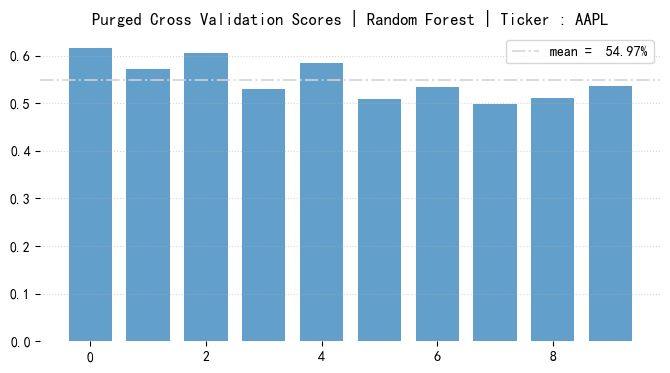

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    range(10),
    -cross_validation_score,
    width = 0.75,
    alpha = 0.7,
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.axhline(
    y = np.mean(-cross_validation_score),
    ls = '-.',
    color = 'lightgray',
    alpha = 0.8,
    label = f'mean = {np.mean(-cross_validation_score) * 100 : .2f}%'
)
plt.legend()
plt.title('Purged Cross Validation Scores | Random Forest | Ticker : AAPL')
plt.show()